In [1]:
!pip install --upgrade jsonmerge
!pip install --upgrade ruamel.yaml
!pip install --upgrade ui

  Running setup.py bdist_wheel for jsonmerge ... done
  Stored in directory: /root/.cache/pip/wheels/55/1b/1a/29f8d1d20b748b3825a0bd52c6a0defdf44aa0d150b5e6df3a
Successfully built jsonmerge
    100% |████████████████████████████████| 133kB 4.6MB/s ta 0:00:01
    100% |████████████████████████████████| 552kB 21.6MB/s ta 0:00:01
  Running setup.py bdist_wheel for ui ... done
  Stored in directory: /root/.cache/pip/wheels/da/d8/19/7004c0b0a7878bf757ca5cd103f6674d2b9c9f0fb8011f535d
Successfully built ui


In [2]:
import pommerman
from pommerman.agents import DullAgent, SimpleAgent
from pommerman.agents.dqn import DQNAgent
from pommerman.agents.ddpg import DDPGAgent
from pommerman.agents.td3 import TD3Agent
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import time

Import error NSDE! You will not be able to render --> Cannot connect to "None"


In [3]:
def train(env, n_episodes=100, max_t=1000):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    # training agent and id
    agent_id = env.training_agent if env.training_agent is not None else 0
    agent = env._agents[agent_id]
    # total_time = 0
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    # eps = eps_start                    # initialize epsilon

    for i_episode in range(1, n_episodes+1):
        states = env.reset()
        score = 0
        for t in range(max_t):
        # while not done:
#             env.render()
            actions = env.act(states)
            if isinstance(agent, DQNAgent):
                next_states, rewards, done, info = env.step(actions)
                agent.step(states[agent_id], actions[agent_id], rewards[agent_id],
                           next_states[agent_id], done)
            else:
                actions, action_probs = [actions[0][0], actions[1]], actions[0][1]
                next_states, rewards, done, info = env.step(actions)
                agent.step(states[agent_id], action_probs, rewards[agent_id],
                           next_states[agent_id], done)
            states = next_states
            score += rewards[agent_id]
            if done:
                break
        if isinstance(agent, DQNAgent):
            agent.update_epsilon()
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        # eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAvg Score: {:.2f}'.format(i_episode,
                                                       np.mean(scores_window)
                                                       ), end="")
        if i_episode % 200 == 0:
            print('\rEpisode {}\tAvg Score: {:.2f}'.format(i_episode,np.mean(scores_window)))
            if isinstance(agent, DQNAgent):
                qnetwork = agent.qnetwork_local.state_dict()
                qnetwork_path = agent.model_path('checkpoint.pth')
                torch.save(qnetwork, qnetwork_path)
            else:
                actor = agent.actor_local.state_dict()
                critic = agent.critic_local.state_dict()
                actor_path = agent.model_path('checkpoint_actor.pth')
                critic_path = agent.model_path('checkpoint_critic.pth')
                torch.save(actor, actor_path)
                torch.save(critic, critic_path)

        # if np.mean(scores_window) >= 200.0:
        #     print('\nEnv solved in {:d} episodes!\tAvg Score: {:.2f}'.
        #           format(i_episode-100, np.mean(scores_window)))
        #     # torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
        #     break
    env.close()
    return scores

In [4]:
# Print all possible environments in the Pommerman registry
print(pommerman.REGISTRY)

# Pick the registry environment
registry = "OneVsOne-v0"
registry2 = "PommeFFAFast-v0"

# agent = DQNAgent(network, replay)
STATE_SIZE = 396
ACTION_SIZE = 6
SEED = 0
agent1 = DQNAgent(state_size=STATE_SIZE, action_size=ACTION_SIZE, seed=SEED)
agent2 = DDPGAgent(state_size=STATE_SIZE, action_size=ACTION_SIZE, seed=SEED)
agent3 = TD3Agent(state_size=STATE_SIZE, action_size=ACTION_SIZE, seed=SEED)
# Create a set of agents (up to four)
agent_list = [agent3, SimpleAgent()]
# Initialize environment
env = pommerman.make(registry2, agent_list)
print(type(env))
print(torch.cuda.is_available())

['PommeFFACompetition-v0', 'PommeFFACompetitionFast-v0', 'PommeFFAFast-v0', 'PommeFFA-v1', 'OneVsOne-v0', 'PommeRadioCompetition-v2', 'PommeRadio-v2', 'PommeTeamCompetition-v0', 'PommeTeamCompetitionFast-v0', 'PommeTeamCompetition-v1', 'PommeTeam-v0', 'PommeTeamFast-v0']
<class 'pommerman.envs.v0.Pomme'>
True


In [9]:
# DQN
start_time = time.time()
scores = train(env, n_episodes=2000)
end_time = time.time()

Episode 200	Avg Score: -0.96
Episode 400	Avg Score: -0.96
Episode 600	Avg Score: -0.96
Episode 800	Avg Score: -0.98
Episode 1000	Avg Score: -0.60
Episode 1200	Avg Score: -0.74
Episode 1400	Avg Score: -0.24
Episode 1600	Avg Score: -0.26
Episode 1800	Avg Score: -0.44
Episode 2000	Avg Score: -0.08


In [10]:
# GPU time
total_time = end_time - start_time
print(f"{round(total_time/60, 2)} min")
env.close()

63.5 min


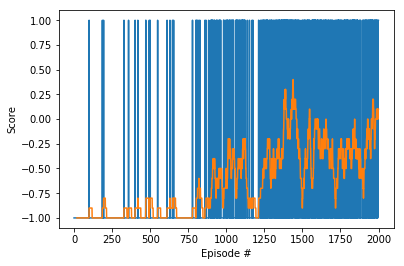

In [16]:
# DQN Plot the scores ##############################################################
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(scores)), pd.DataFrame(scores).rolling(20).mean())
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [5]:
# DDPG
start_time = time.time()
scores = train(env, n_episodes=2000)
end_time = time.time()

Episode 200	Avg Score: -0.10
Episode 400	Avg Score: -0.18
Episode 600	Avg Score: -0.24
Episode 800	Avg Score: -0.08
Episode 1000	Avg Score: -0.10
Episode 1200	Avg Score: -0.22
Episode 1400	Avg Score: 0.002
Episode 1600	Avg Score: -0.08
Episode 1800	Avg Score: -0.18
Episode 2000	Avg Score: -0.08


In [6]:
# GPU time
total_time = end_time - start_time
print(f"{round(total_time/60, 2)} min")
env.close()

192.85 min


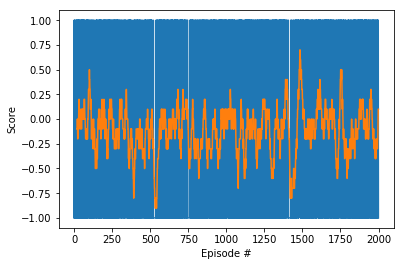

In [7]:
# DDPG Plot the scores ##############################################################
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(scores)), pd.DataFrame(scores).rolling(20).mean())
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [5]:
# TD3
start_time = time.time()
scores = train(env, n_episodes=2000)
end_time = time.time()

Episode 200	Avg Score: -0.74
Episode 400	Avg Score: -0.70
Episode 600	Avg Score: -0.84
Episode 800	Avg Score: -0.74
Episode 1000	Avg Score: -0.84
Episode 1200	Avg Score: -0.86
Episode 1400	Avg Score: -0.80
Episode 1600	Avg Score: -0.72
Episode 1800	Avg Score: -0.80
Episode 2000	Avg Score: -0.82


In [6]:
# GPU time
total_time = end_time - start_time
print(f"{round(total_time/60, 2)} min")
env.close()

37.84 min


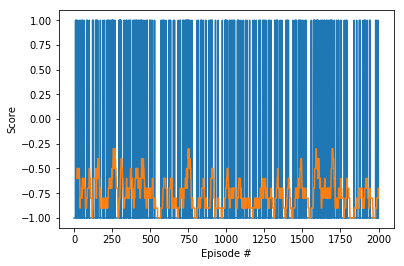

In [7]:
# TD3 Plot the scores ##############################################################
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(scores)), pd.DataFrame(scores).rolling(20).mean())
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()